# Job Recommendation Using Knowledge Graph

In [132]:
import networkx as nx
import pandas as pd
from pyvis.network import Network
from operator import itemgetter
import matplotlib.pyplot as plt
from IPython.display import display
import collections
import warnings
warnings.filterwarnings("ignore")
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules

In [133]:
resume_counts=20
jd_count=20

In [134]:
nx.__version__

'2.6.3'

In [135]:
job_description_dataset = pd.read_json(
    "Dataset\dataset_job_description.json")
job_description_dataset.head(n=5)



,salary,domain,education,crawled_at,description,title,skills,country,raw_description,locality,...,longitude,postalCode,url,experience,address,latitude,_id,company,region,employment_type
0,$17.23 - $22.00 / hour,https://www.careerbuilder.com/,Bachelor's Degree,2021-05-05 03:01:49,Job Description\nTo implement the Head Start P...,Head Start Teacher,"Microsoft Office , java ee , cics , Adobe Phot...",US,\n\n<strong>Job Description</strong>\n<span>To...,Rochester,...,-77.59785,14604,https://www.careerbuilder.com/job/J8S02F6YRMG5...,1 to 2 years experience.,550 East Main Street,43.15929,2b387592-8148-5720-a661-a2730061d14c,"Action for a Better Community, Inc.",NY,FULL_TIME
1,$19.00 - $26.00 / hour,https://www.careerbuilder.com/,Graduate Degree,2021-05-05 03:01:50,Job Description\nYou have the magic. We have t...,Teacher of English for Online Groups!,"Team and individual development  , c",US,\n\n<strong>Job Description</strong>\n<p style...,Atlanta,...,-84.38799,,https://www.careerbuilder.com/job/JCL1H264YM6F...,No experience required.,,33.74900,cfc728ee-e7f8-5538-b1ee-0f6a2d12e1d1,Magic Ears,GA,PART_TIME
2,"$106,250.00 - $125,000.00 / year",https://www.careerbuilder.com/,Bachelor's Degree,2021-05-05 03:01:50,Job Description\nWe are looking for a CRM deve...,CRM / PHP Developer,"WebSphere Datapower , Visual Basic For Excel ,...",US,\n\n<strong>Job Description</strong>\n<p class...,Duluth,...,-84.17516,30097,https://www.careerbuilder.com/job/JCM4J76JP92B...,At least 5 years experience.,,34.04884,8dcd846b-db99-547f-836c-bcda497cff0d,ExecuSource,GA,FULL_TIME
3,,https://www.careerbuilder.com/,High School,2021-05-05 03:01:50,Job Description\n\nBriggs Dodge Ram Fiat is lo...,Automotive Service Advisor / Driver,"Hr Auditing , Xml Web Services , MFC , Problem...",US,\n\n<strong>Job Description</strong>\n<p style...,Topeka,...,-95.68294,66611,https://www.careerbuilder.com/job/JCH4GH71PST9...,No experience required.,3001 South Kansas Avenue,39.01264,e7fc9e40-ac86-5cf2-ba8f-3c1ef9e21982,Briggs Dodge Ram Fiat,KS,FULL_TIME
4,"$85,000.00 - $120,000.00 / year",https://www.careerbuilder.com/,4 Year Degree,2021-05-05 03:01:50,"Job Description\n HARLINGEN, TX- RIO GRANDE VA...",Licensed Nursing Home Administrator,"Unix , knowledge of word , Internet Procuremen...",US,\n\n<strong>Job Description</strong>\n<p style...,Harlingen,...,-97.65767,78550,https://www.careerbuilder.com/job/JCM2C66SCC02...,At least 3 years experience.,1814 Atrium Place Drive,26.16793,0d4d608a-17c0-5e6b-827e-88ad505cad09,Regency Integrated Health Services,TX,FULL_TIME


In [136]:
resume_dataset = pd.read_json("Dataset\dataset_resume.json")


resume_dataset.head(n=5)




,resumes
0,"{'id': 1, 'careerjunction_za_historical_jobtit..."
1,"{'id': 2, 'careerjunction_za_historical_jobtit..."
2,"{'id': 3, 'careerjunction_za_historical_jobtit..."
3,"{'id': 4, 'careerjunction_za_historical_jobtit..."
4,"{'id': 5, 'careerjunction_za_historical_jobtit..."


In [137]:
jd_total_count=len(job_description_dataset)
resume_total_count = len(resume_dataset)

print(f"Total Job Descriptions {jd_total_count}")
print(f"Total Resumes {resume_total_count}")

#!  uncomment to load entire dataset
resume_counts = resume_total_count
jd_count = jd_total_count



Total Job Descriptions 10501
Total Resumes 2000


In [138]:
for resumeData in resume_dataset.values[:1] : # first two resumes
    print(resumeData[0]['id']) #id
    print(resumeData[0]['careerjunction_za_skills']) # skills
    print(resumeData[0]['careerjunction_za_courses']) # Degree 
    print(f" Experience {len(resumeData[0]['careerjunction_za_historical_jobtitles'])}") # Experience


1
['asp', 'asp. NET', 'Adobe Photoshop', 'Emergency Handling', 'Microbiology', 'microsoft powerpoint', 'microsoft office', 'microsoft excel', 'microsoft project management', 'Microsoft word', 'Outlook', 'BootStrap', 'Internet explorer', 'Marketing/Sales', 'Quality Control', 'Quality Assurance', 'Research and development', 'Problem solving']
['Btech: Food Technology', 'National Diploma: Food Technology', 'Senior Certificate']
 Experience 5


In [139]:
for jobData in job_description_dataset[:1].values:  # first two job description
    print(jobData[17])  # Id
    print(jobData[0])  # Salary
    print(jobData[6])  # Skills
    print(jobData[2])  # Degree
    numbers = [int(word) for word in jobData[14].split() if word.isdigit()]
    numbers.append(0)
    experience = max(numbers) 
    print(experience) # Experience
    print(jobData[20])  # Job Type


2b387592-8148-5720-a661-a2730061d14c
$17.23 - $22.00 / hour
Microsoft Office , java ee , cics , Adobe Photoshop , asp , Adobe After Effects , Powerhouse Programming- beginners and advance , asp .NET
Bachelor's Degree
2
FULL_TIME


In [140]:
nodes = [n for n in resume_dataset.values][:resume_counts] # TODO: Change count to desired no of resumes

nodes_id=[n[0]['id'] for n in nodes]
# nodes_id

edges = [tuple(e) for e in job_description_dataset.values]
# edges

Extract Job Id, Skills and experience from job post

In [141]:
G = nx.Graph()

jobid = []
req_skills = []
req_experience = []

counter = 0

for job in job_description_dataset[:jd_count].values: # TODO: Change count to desired no of JD
    _skills = job[6].split(",")
    jobid.append(job[17])
    req_skills.append(_skills)
    numbers = [int(word) for word in job[14].split() if word.isdigit()]
    numbers.append(0)
    experience = max(numbers)
    req_experience.append(experience)
    counter += 1
    if(counter == jd_count):  # TODO: Change count to desired no of JD
        break

print(len(jobid))


10501


Extract resume Id, Skills and experience from Resume

In [142]:

resumeId = []
resumeSkills = []
resumeExperience = []
# Side note: use a for loop instead of individual loops

resumes = [n for n in resume_dataset.values][:resume_counts] # TODO: Change count to desired no of resumes
resumeId = [n[0]['id'] for n in resumes]
resumeSkills = [n[0]['careerjunction_za_skills'] for n in resumes]
resumeExperience = [
    len(n[0]['careerjunction_za_historical_jobtitles']) for n in resumes]
print(len(resumeId))


2000


In [143]:
edge_data = zip(jobid, req_skills, req_experience)
node_data = zip(resumeId, resumeSkills, resumeExperience)

In [144]:
resumeSkills

[['asp',
  'asp. NET',
  'Adobe Photoshop',
  'Emergency Handling',
  'Microbiology',
  'microsoft powerpoint',
  'microsoft office',
  'microsoft excel',
  'microsoft project management',
  'Microsoft word',
  'Outlook',
  'BootStrap',
  'Internet explorer',
  'Marketing/Sales',
  'Quality Control',
  'Quality Assurance',
  'Research and development',
  'Problem solving'],
 ['MVC5',
  'JQuery',
  'C#',
  'BootStrap',
  'REST Services',
  'EntityFrameWork 6',
  'SQL Databse Development',
  'Emergency Handling',
  'SSRS',
  'SSIS'],
 ['C# Developer',
  'MYSQL',
  'cics',
  'PHP',
  'javascript',
  'CSS3',
  'HTML5',
  'wordpress',
  'AJAX',
  'RDBMS',
  'Magento',
  'C++ Developer',
  'JAVA Developer'],
 ['Programming', 'Technical Support'],
 ['Java', 'delphi', 'Excel', 'excel', 'Bloomberg'],
 ['communication skills',
  'Microsoft office',
  'MVC',
  'JavaScript',
  'css',
  'codeigniter',
  'html',
  'PHP',
  'Microsoft excel',
  'Photoshop',
  'java'],
 ['PHP',
  'SQL',
  'Javascript'

In [145]:
sub=zip(resumeId, resumeSkills)
aprioriData1 = pd.DataFrame(sub)
aprioriData1

,0,1
0,1,"[asp, asp. NET, Adobe Photoshop, Emergency Han..."
1,2,"[MVC5, JQuery, C#, BootStrap, REST Services, E..."
2,3,"[C# Developer, MYSQL, cics, PHP, javascript, C..."
3,4,"[Programming, Technical Support]"
4,5,"[Java, delphi, Excel, excel, Bloomberg]"
...,...,...
1995,1996,"[Java Script, SQL, Delphi 6, Firebird Database..."
1996,1997,"[Asp.Net, Javascript, C#, Sql Server 2005, Java]"
1997,1998,"[N+, software engineering, C#, networks, proje..."
1998,1999,"[Micrsoft Office Suite, Double Chocco Latte (T..."


In [146]:
apridata = []
# Only take first 500 rows
count=2000;
for index,data in aprioriData1.iterrows():
    eachapridata=[]
    eachapridata.append(data[0])
    eachapridata.append(data[1])
    apridata.append(eachapridata)
    count-=1
    if(count<=0):
        break
# print(apridata)
data=apridata
data

[[1,
  ['asp',
   'asp. NET',
   'Adobe Photoshop',
   'Emergency Handling',
   'Microbiology',
   'microsoft powerpoint',
   'microsoft office',
   'microsoft excel',
   'microsoft project management',
   'Microsoft word',
   'Outlook',
   'BootStrap',
   'Internet explorer',
   'Marketing/Sales',
   'Quality Control',
   'Quality Assurance',
   'Research and development',
   'Problem solving']],
 [2,
  ['MVC5',
   'JQuery',
   'C#',
   'BootStrap',
   'REST Services',
   'EntityFrameWork 6',
   'SQL Databse Development',
   'Emergency Handling',
   'SSRS',
   'SSIS']],
 [3,
  ['C# Developer',
   'MYSQL',
   'cics',
   'PHP',
   'javascript',
   'CSS3',
   'HTML5',
   'wordpress',
   'AJAX',
   'RDBMS',
   'Magento',
   'C++ Developer',
   'JAVA Developer']],
 [4, ['Programming', 'Technical Support']],
 [5, ['Java', 'delphi', 'Excel', 'excel', 'Bloomberg']],
 [6,
  ['communication skills',
   'Microsoft office',
   'MVC',
   'JavaScript',
   'css',
   'codeigniter',
   'html',
   'PHP

In [147]:
te = TransactionEncoder()
te_ary = te.fit(resumeSkills).transform(resumeSkills)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df, min_support=0.1, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.1815,(C#)
1,0.1705,(Java)
2,0.1675,(SQL)
3,0.1125,(Javascript)
4,0.1110,(Project Management)
5,0.1030,(Microsoft Office)
6,0.1330,(HTML)


In [148]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.05)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [149]:
init = []
for i in data:
    for q in i[1]:
        if(q not in init):
            init.append(q)
init = sorted(init)

print(len(init))

12514


In [150]:
sp = 0.2
s = int(sp*len(init))
s

2502

In [151]:
from collections import Counter
c = Counter()
for i in init:
    for d in data:
        if(i in d[1]):
            c[i]+=1
print("C1:")
for i in c:
    print(str([i])+": "+str(c[i]))
print()
l = Counter()
for i in c:
    if(c[i] >= s):
        l[frozenset([i])]+=c[i]
print("L1:")
for i in l:
    print(str(list(i))+": "+str(l[i]))
print()
pl = l
pos = 1
for count in range (2,1000):
    nc = set()
    temp = list(l)
    for i in range(0,len(temp)):
        for j in range(i+1,len(temp)):
            t = temp[i].union(temp[j])
            if(len(t) == count):
                nc.add(temp[i].union(temp[j]))
    nc = list(nc)
    c = Counter()
    for i in nc:
        c[i] = 0
        for q in data:
            temp = set(q[1])
            if(i.issubset(temp)):
                c[i]+=1
    print("C"+str(count)+":")
    for i in c:
        print(str(list(i))+": "+str(c[i]))
    print()
    l = Counter()
    for i in c:
        if(c[i] >= s):
            l[i]+=c[i]
    print("L"+str(count)+":")
    for i in l:
        print(str(list(i))+": "+str(l[i]))
    print()
    if(len(l) == 0):
        break
    pl = l
    pos = count
print("Result: ")
print("L"+str(pos)+":")
for i in pl:
    print(str(list(i))+": "+str(pl[i]))
print()

C1:
['&amp; Business Law']: 1
["'"]: 1
['(Sql, Pl\\Sql,Vb, Database S']: 1
['(X)Html/ Xml']: 1
['*Vendor Experience: Ericsson/Hawaii multiplexer environ']: 1
['-']: 3
['-Android \n-Java EE \n-MySQL /PLSQL \n-XML \n-Servlet \n-JSON \n-Restful Web Services \n-vb   .NET \n-Microsoft Office Tools \n-HTML']: 1
['-MySQL -MsSQL -Oracle 11g -DB2']: 1
['....']: 1
['.NET']: 37
['.NET (Asp,C#)']: 1
['.NET (C#, JavaScript, Web, C++, VB)']: 1
['.NET (C#/Visual Basic)']: 1
['.NET (Vb.Net,C#.Net,Asp.Net']: 1
['.NET - C# / Web Services / Winforms']: 1
['.NET 1 And 2']: 1
['.NET C#']: 1
['.NET C# (Web Development, Application Development)']: 1
['.NET Compact Framework 3.5']: 1
['.NET Developer']: 1
['.NET Development']: 2
['.NET Environment']: 1
['.NET FRAMEWORK']: 1
['.NET Frame Work 1.0,1.1,2.0,3.0,3.5']: 1
['.NET Frame Work/1.1/2.0/3.0/Asp .NET Ajax,Html,Xml']: 1
['.NET Framework']: 3
['.NET Framework , C#, Asp.Net, Windows Forms']: 1
['.NET Framework 2.0']: 1
['.NET Framework 3.5']: 1
['.NET Micro'

In [152]:
from itertools import combinations
for l in pl:
    c = [frozenset(q) for q in combinations(l,len(l)-1)]
    mmax = 0
    for a in c:
        b = l-a
        ab = l
        sab = 0
        sa = 0
        sb = 0
        for q in data:
            temp = set(q[1])
            if(a.issubset(temp)):
                sa+=1
            if(b.issubset(temp)):
                sb+=1
            if(ab.issubset(temp)):
                sab+=1
        temp = sab/sa*100
        if(temp > mmax):
            mmax = temp
        temp = sab/sb*100
        if(temp > mmax):
            mmax = temp
        print(str(list(a))+" -> "+str(list(b))+" = "+str(sab/sa*100)+"%")
        print(str(list(b))+" -> "+str(list(a))+" = "+str(sab/sb*100)+"%")
    curr = 1
    print("choosing:", end=' ')
    for a in c:
        b = l-a
        ab = l
        sab = 0
        sa = 0
        sb = 0
        for q in data:
            temp = set(q[1])
            if(a.issubset(temp)):
                sa+=1
            if(b.issubset(temp)):
                sb+=1
            if(ab.issubset(temp)):
                sab+=1
        temp = sab/sa*100
        if(temp == mmax):
            print(curr, end = ' ')
        curr += 1
        temp = sab/sb*100
        if(temp == mmax):
            print(curr, end = ' ')
        curr += 1
    print()
    print()

Adding Job Description and skill node, are connected with an edge having weight of **experience**

In [153]:
for j, e in enumerate(edge_data):
    src = e[0]
    dst = e[1]
    w = e[2]
    # print(dst)
    G.add_node(src, color='#dd4b39', title=src,type='jobDescription')
    for eachSkill in dst:
        eachSkill=eachSkill.strip()
        G.add_node(eachSkill, title=dst, type='skill', experience=w)
        # if str(w).isdigit():
        if w is None:
            G.add_edge(src, eachSkill, value=w, color='#00ff1e', label=w)
        if 1 < w <= 70000:
            G.add_edge(src, eachSkill, value=w, color='#FFFF00', label=w)
        if w > 70000:
            G.add_edge(src, eachSkill, value=w, color='#dd4b39', label=w)

        else:
            G.add_edge(src, eachSkill) 


Adding resume and skill node, are connected with an edge

In [154]:
for j, e in enumerate(node_data):
    src = "ResumeId-" + str(e[0])
    dst = e[1]
    w = e[2]
    G.add_node(src, color='#dd4b39', type='resume', title=src)
    for eachSkill in dst:
        eachSkill = eachSkill.strip()
        G.add_node(eachSkill, title=eachSkill, type='skill', experience=w)
        G.add_edge(src, eachSkill, color='#00ff1e')

nt = Network('1080px', '1960px', notebook=False)

# populates the nodes and edges data structures
nt.from_nx(G)
nt.show('nx.html')


KeyboardInterrupt: 

## Analysis of Network


In [ ]:
nx.info(G)


'Graph with 374 nodes and 426 edges'

#### Find Skills ,Job Description , Resume having highest degree. (which means highest connections)
- Most influential among them all
- Who is the most influetial?
- nx.degree_centrality(g)


In [ ]:
degree_dict = nx.degree_centrality(G)
nx.set_node_attributes(G,degree_dict,'degree')

sorted_degree= sorted(degree_dict.items(),key=itemgetter(1),reverse=True)

def popularNodeByType(type):
  for d in sorted_degree:
    if(G.nodes[d[0]]['type'] == type):
        print(f"{d}\n")
        return d;

print("Popular Skill:")
popular_skill=popularNodeByType('skill')

print("Popular Resume:")
popular_resume=popularNodeByType('resume')

print("Popular Description:")
popular_jd=popularNodeByType('jobDescription')




Popular Skill:
('C#', 0.02412868632707775)

Popular Resume:
('ResumeId-20', 0.07238605898123325)

Popular Description:
('53975ae6-ae18-5dd5-8f64-a4e378a7b9b9', 0.05361930294906166)



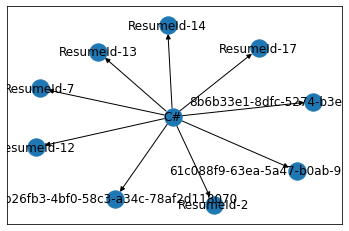

In [ ]:
pop_skill_g = nx.bfs_tree(G, popular_skill[0], depth_limit=1)

nx.draw_networkx(pop_skill_g)


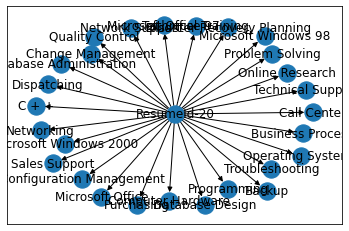

In [ ]:
pop_resume_g = nx.bfs_tree(G, popular_resume[0], depth_limit=1)
nx.draw_networkx(pop_resume_g)


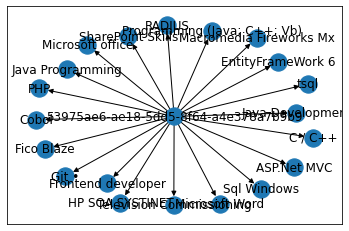

In [ ]:
pop_jd_g = nx.bfs_tree(G, popular_jd[0], depth_limit=1)
nx.draw_networkx(pop_jd_g)


In [ ]:
D=nx.average_neighbor_degree(G)
sorted_x = sorted(
    D.items(), key=itemgetter(1), reverse=True)
D=collections.OrderedDict(sorted_x)


([], [])

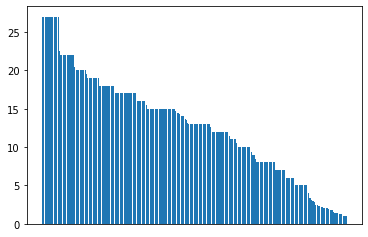

In [ ]:
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks([])


#### Eigen vector centrality take an account of nodes , edges as well as connections of that nodes
- Eigenvector Centrality
    - Most important connection
    - Do you know whom I am related to?
    - eg Google Page Rank

Eigenvector Centrality is an algorithm that measures the transitive influence of nodes. Relationships originating from high-scoring nodes contribute more to the score of a node than connections from low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores.

In [ ]:
betweenness_dict = nx.betweenness_centrality(G,weight=True)  # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G,max_iter=600,weight=True)  # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

sorted_betweenness = sorted(
    eigenvector_dict.items(), key=itemgetter(0), reverse=True)

print("Top 20 nodes by eigenvector centrality:")
count=0;
for b in sorted_betweenness:
    if(G.nodes[b[0]]['type']=='resume'):
        print(b)
        count+=1
    if count==20:
        break



Top 20 nodes by eigenvector centrality:
('ResumeId-9', 0.020957184915277042)
('ResumeId-8', 0.06633551033414514)
('ResumeId-7', 0.3467484607814514)
('ResumeId-6', 0.12442103525717838)
('ResumeId-5', 0.04224966886283516)
('ResumeId-4', 0.00752700448449583)
('ResumeId-3', 0.07260664371520024)
('ResumeId-20', 0.06278848807287965)
('ResumeId-2', 0.07493558691351837)
('ResumeId-19', 0.0012535527897914488)
('ResumeId-18', 0.13124219692967637)
('ResumeId-17', 0.36304815935062534)
('ResumeId-16', 0.04724645944935945)
('ResumeId-15', 0.024351295511403845)
('ResumeId-14', 0.1386824897816205)
('ResumeId-13', 0.09520772556818693)
('ResumeId-12', 0.05378066195578652)
('ResumeId-11', 6.440801937629768e-39)
('ResumeId-10', 1.1532755714343616e-20)
('ResumeId-1', 0.01588310133861768)


**Input**: skill
**Output:** recommend (description,
        resumes)

In [ ]:
allConnectedNodes=nx.node_connected_component(G, 'BootStrap')
for node in allConnectedNodes:
    print(node)

ResumeId-15
It Operations Management
Change Management
Internet Procurement
Silk Central
Disaster Recovery Planning
budget allocation
LESS
css
Web developer
.Net
ResumeId-20
ColdFusion
Prince2 Project Management
Microsoft Software Packages
PostgreSQL
ResumeId-1
RADIUS
Technical Training
Database Administration
Programming (Java; C++; Vb)
Test Management
Information risk management
Windows 7
Linux
Unique
Networks
Designer
Business Analytics
0242a07f-aae1-56cf-a264-53eb2b402d89
Data
Hyperion Analyzer
Bloomberg
ResumeId-9
HTML
ResumeId-7
Project management
Java Development
sql
MS SQL Server
android
Cobol
Web Development
UML
ASP
ResumeId-6
Senior Developer
WCF
Git •
Archi
analytical
Systems Analysis
Ability To Work In A Team
C Programming Language
Iis 4/5
sqlserver
Purchasing
Microsoft Windows 98
6e18743d-a5af-5dc1-a6b1-20d293705199
communication skills
tsql
Borland C++
C + +
Microsoft Word
Informatica
Leadership
Hr Auditing
Programming
cics
Microsoft Office
MFC
Processes & Projectmanageme

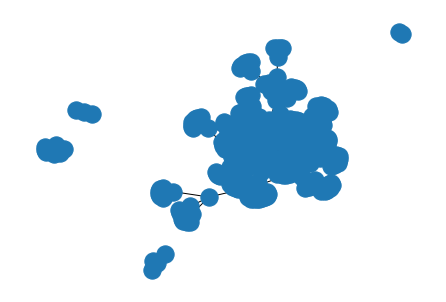

In [ ]:
nx.draw_spring(G)

### Predicting Associations
- Clusting Coefficient
- nx.clustering(Graph, Node)
- nx.average_clustering(g)

In [ ]:
nx.average_clustering(G)


0.0

#### Recommend Users to learn skills
[Bipertite graph concept applies here]

In [ ]:
resume1_nbrs=G.neighbors('ResumeId-2')

resume3_nbrs=G.neighbors('ResumeId-3')

differentSkills= set(resume1_nbrs).difference(resume3_nbrs)
skillNodes=[]

for skill in differentSkills:
    skillNodes.append(G.nodes[skill])
    
sortedSkillsAccrToEigen = sorted(skillNodes, key=lambda i: i['eigenvector'],reverse=True)

print("Top Skills to be learned")
for skill in sortedSkillsAccrToEigen:
    print(f"{skill['title']} {round(skill['eigenvector'],3)}")





Top Skills to be learned
C# 0.254
SSIS 0.059
EntityFrameWork 6 0.036
Emergency Handling 0.015
BootStrap 0.015
REST Services 0.013
SSRS 0.013
JQuery 0.013
MVC5 0.013
SQL Databse Development 0.013


In [ ]:
hh = list(G.neighbors('C#'))
len(hh)


9

#### input: Resume 

#### output: List of recommended Job Descriptions

In [ ]:
def get_all_adj_job_description_nodes(resume3_nbrs):
    related_job_description_nodes_dict = {}

    for skill in resume3_nbrs:
        skill_nabhour = G.neighbors(skill)
        for each_node in skill_nabhour:
            if(G.nodes[each_node]['type'] == 'jobDescription'):
                if G.nodes[each_node]['title'] in related_job_description_nodes_dict:
                    related_job_description_nodes_dict[G.nodes[each_node]
                                                       ['title']] += 1
                else:
                    related_job_description_nodes_dict[G.nodes[each_node]
                                                       ['title']] = 1

    return related_job_description_nodes_dict


resume3_nbrs = G.neighbors('ResumeId-20')
# resume3_nbrs = G.neighbors('ResumeId-1')
jobDescriptionNodes = get_all_adj_job_description_nodes(resume3_nbrs)

sortedJobDescriAccToConNodes = dict(sorted(
    jobDescriptionNodes.items(), key=lambda i: i[1], reverse=True))

print("Recomended Job Descriptions")
x_train_data=[]
for job in sortedJobDescriAccToConNodes:
    x_train_data.append(job)
    print(f"{job} {sortedJobDescriAccToConNodes[job]}")


Recomended Job Descriptions
2b387592-8148-5720-a661-a2730061d14c 1
2fea03fb-e855-596f-915c-f2feb28da9fb 1
d6dd4a06-0afb-5a15-8fb7-85c2b8c54ea4 1
e7fc9e40-ac86-5cf2-ba8f-3c1ef9e21982 1
3245816c-1ae2-53db-9e31-ee6dfa591981 1
0242a07f-aae1-56cf-a264-53eb2b402d89 1
61c088f9-63ea-5a47-b0ab-9310db497b4d 1


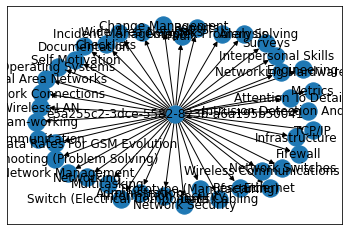

In [ ]:
pop_skill_g = nx.bfs_tree(
    G, "e5a255c2-3dce-5582-823b-a6a195b50041", depth_limit=1)

nx.draw_networkx(pop_skill_g)
